In [1]:
# Library imports
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import pennylane as qml
import h5py

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



# Set the random seed for reproducibility
seed = 24
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
with h5py.File("/home/reyguadarrama/GSoC/data/gluon_data/gluon_ECAL_sumpool_8x8.h5", 'r') as file:
    all_gluon_8x8 = file['gluon_ECAL_sumpool_8x8'][:]

In [3]:
total_energy = np.sum(all_gluon_8x8, axis=(1,2))
max_energy_dep = np.max(all_gluon_8x8, axis=(1, 2))

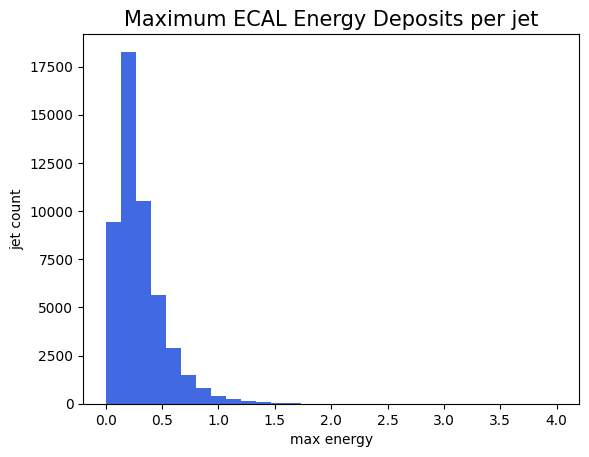

In [4]:
plt.hist(max_energy_dep, range=(0, 4), bins=30, color="royalblue")
plt.title("Maximum ECAL Energy Deposits per jet", fontsize=15)
plt.xlabel("max energy")
plt.ylabel("jet count")
plt.show()

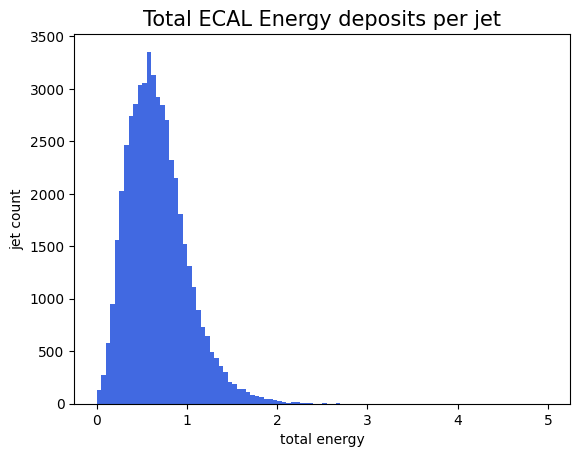

In [5]:
plt.hist(total_energy, range=(0, 5), bins=100, color="royalblue")
plt.title("Total ECAL Energy deposits per jet", fontsize=15)
plt.xlabel("total energy")
plt.ylabel("jet count")
plt.show()

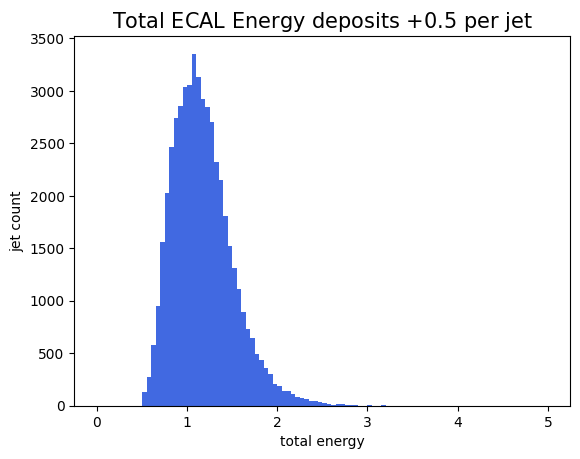

In [6]:
plt.hist(total_energy+0.5, range=(0, 5), bins=100, color="royalblue")
plt.title("Total ECAL Energy deposits $+0.5$ per jet", fontsize=15)
plt.xlabel("total energy")
plt.ylabel("jet count")
plt.show()

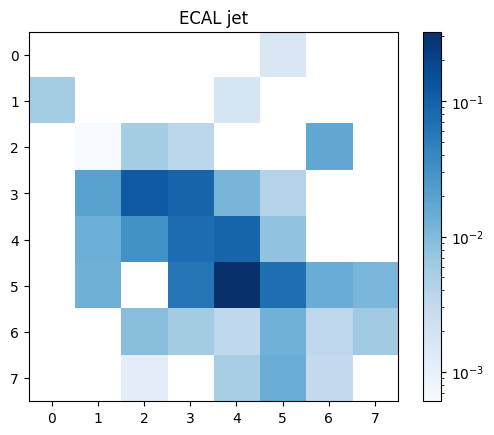

In [7]:
plt.imshow(all_gluon_8x8[0], cmap="Blues", norm=mcolors.LogNorm())
plt.title("ECAL jet")
plt.colorbar()
plt.show()

In [8]:
shifted_gluon_8x8 = all_gluon_8x8+0.1

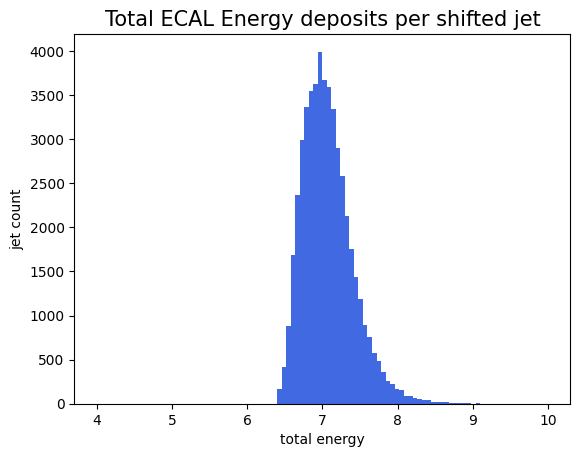

In [9]:
plt.hist(np.sum(shifted_gluon_8x8, axis=(1,2)), range=(4, 10), bins=100, color="royalblue")
plt.title("Total ECAL Energy deposits per shifted jet", fontsize=15)
plt.xlabel("total energy")
plt.ylabel("jet count")
plt.show()

In [10]:
class QuarkDataset(Dataset):
    def __init__(self, image):
        self.data = torch.tensor(image, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
batch_size = 1 

# Quantum variables
n_qubits = 8  # Total number of qubits / N
n_a_qubits = 2  # Number of ancillary qubits / N_A
q_depth = 8  # Depth of the parameterised quantum circuit / D
n_generators = 1  # Number of subgenerators for the patch method / N_G

lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 1400  # Number of training iterations


In [12]:
# Create the data loader instance
dataset = QuarkDataset(shifted_gluon_8x8.reshape(50000, 64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(64, 128),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(128, 64),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [14]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="backprop")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [15]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)
            


        return images 

In [16]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, data in enumerate(dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * np.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,8,8).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.391, Generator Loss: 0.746
Iteration: 20, Discriminator Loss: 1.373, Generator Loss: 0.756
Iteration: 30, Discriminator Loss: 1.384, Generator Loss: 0.742
Iteration: 40, Discriminator Loss: 1.374, Generator Loss: 0.751
Iteration: 50, Discriminator Loss: 1.376, Generator Loss: 0.744
Iteration: 60, Discriminator Loss: 1.384, Generator Loss: 0.733
Iteration: 70, Discriminator Loss: 1.390, Generator Loss: 0.727
Iteration: 80, Discriminator Loss: 1.373, Generator Loss: 0.737
Iteration: 90, Discriminator Loss: 1.383, Generator Loss: 0.724
Iteration: 100, Discriminator Loss: 1.383, Generator Loss: 0.723
Iteration: 110, Discriminator Loss: 1.376, Generator Loss: 0.728
Iteration: 120, Discriminator Loss: 1.380, Generator Loss: 0.723
Iteration: 130, Discriminator Loss: 1.377, Generator Loss: 0.723
Iteration: 140, Discriminator Loss: 1.384, Generator Loss: 0.716
Iteration: 150, Discriminator Loss: 1.383, Generator Loss: 0.716
Iteration: 160, Discriminator Loss

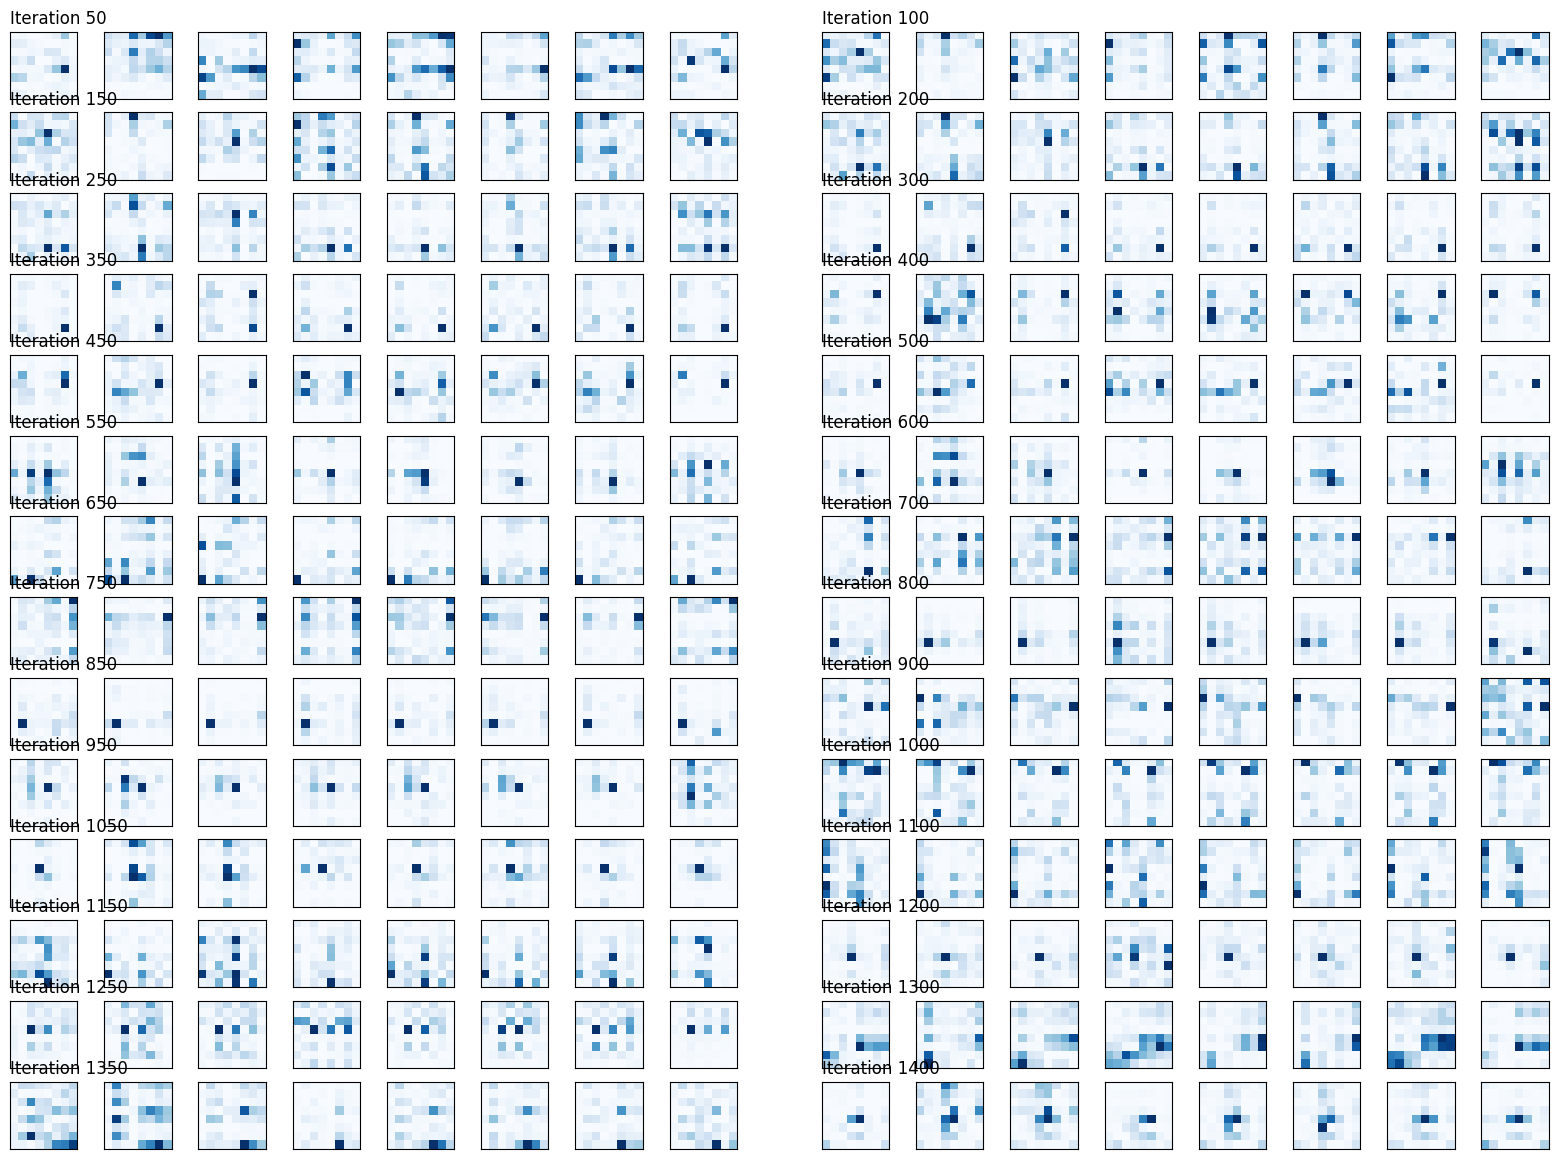

In [18]:
fig = plt.figure(figsize=(20, 25))
outer = gridspec.GridSpec(24, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="Blues")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

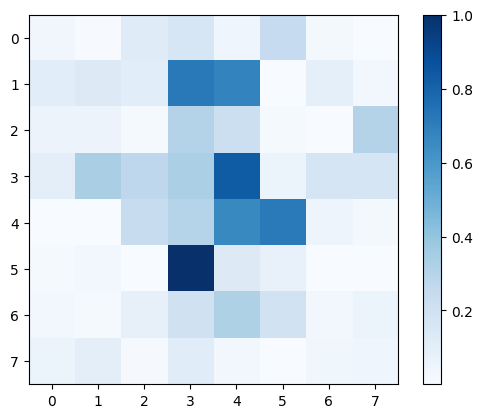

In [61]:
jet = generator(torch.rand(batch_size, n_qubits, device=device) * np.pi / 2).detach().numpy().reshape(8, 8)
plt.imshow(jet, cmap='Blues')
plt.colorbar()
plt.show()

In [55]:
gen_jets = []

for _ in range(3000):
    jet = generator(torch.rand(batch_size, n_qubits, device=device) * np.pi / 2).detach().numpy().reshape(8, 8)
    gen_jets.append(jet)

gen_jets = np.array(gen_jets)

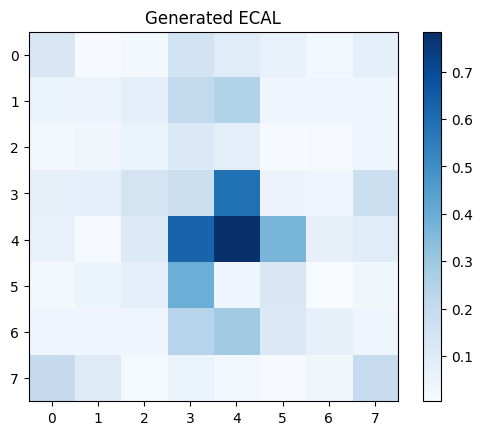

In [57]:
gen_jets_image = np.mean(gen_jets, axis=0)

plt.imshow(gen_jets_image, cmap='Blues')
plt.title("Generated ECAL")
plt.colorbar()
plt.show()

In [63]:
gen_total_energy = np.sum(gen_jets, axis=(1,2))
gen_max_energy_dep = np.max(gen_jets, axis=(1, 2))

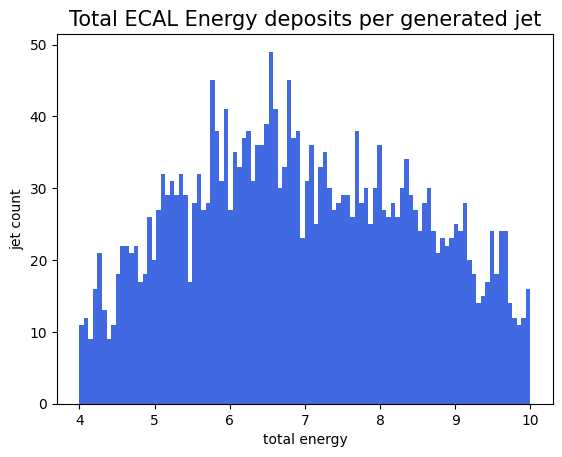

In [65]:
plt.hist(gen_total_energy, range=(4, 10), bins=100, color="royalblue")
plt.title("Total ECAL Energy deposits per generated jet", fontsize=15)
plt.xlabel("total energy")
plt.ylabel("jet count")
plt.show()